In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [6]:
# load in relevant data



In [23]:
def u0_gaussian(z, G_w = 0.5, G_a = 1e-6, z_s = 300):
    return G_a*(np.exp(-((z - z_s)/G_w)**2) - np.exp(-((-z - z_s)/G_w)**2))

def c_given(f, r, z):
    # load in SSP table
    ssp_filename = '2017-002-FA_CTD24.svp'
    ssp_full_filename = '/Users/matthewcasali/Documents/PythonScripts/acoustic-models/SSP_USGS/' + ssp_filename
    try:
        with open(ssp_full_filename, 'r') as file:
            content = file.read()
            content = content.split('\n')[3:-1]
            content = [item.split(' ') for item in content]
            converted_list = np.array([[float(item) for item in sublist] for sublist in content])
            z_ssp = converted_list[:,0] # [m] corresponding vertical coordinates for ssp
            ssp = converted_list[:,1] # [m/s] sound speed profile, https://doi.org/10.5066/P9Y1MSTN
            ssp_cs = scipy.interpolate.CubicSpline(z_ssp, ssp)
    except FileNotFoundError:
        print(f"Error: {file} was not found.", file = ssp_filename)
    c_start = ssp_cs(z)
    c = np.tile(np.append(np.append(1e-6, c_start), c_start[-1]), (np.size(r),1))
    return c 

def surf_test(r, k_0):
    return np.zeros_like(r)

def bottom_test(r, 

# --- burger test ---
def u0_burger(z, k_0):
    return 1 / (1 + np.exp(-1j*k_0*z/2))

def surf_burger(r, k_0):
    return 1 / (1 + np.exp(1j*r*k_0/2))

def bottom_burger(r, k_0, z_max):
    return 1 / (1 + np.exp(1j*k_0/2*(-2*z_max + r)))

def c_burger(f, r, z, c_0 = 1500):
    if len(np.shape(r)) == 1:
        r = r[:,np.newaxis]
        z = z[:,np.newaxis]
    Z, R = np.meshgrid(z, r)
    c = c_0*np.sqrt(1 + (1 / (np.cos(2*np.pi*f/c_0*(Z - 0.5*R)))))
    c = np.append(1e-6*np.ones_like(r), c, axis = 1)
    c = np.append(c, c_0*np.ones_like(r), axis = 1)
    return c

In [24]:
# implicit scheme for finite difference calculations
# the following was created using the implicit scheme defined in the report:
# IFD: An Implicit Finite-Difference Computer Model for Solving the Parabolic Equation (Botseas 1982)

def ifd_pe(f, r, z, c_func, u0_func, surf_func, bottom_func, k = None, h = None):

    if type(k) == type(None):
        k = c_func(f, np.zeros(10), np.zeros(10))[0,0]/f/6 # [m] step size in range
        r = np.arange(0,r[-1],k)
    if type(h) == type(None):
        h = c_func(f, np.zeros(10), np.zeros(10))[0,0]/f/6 # [m] step size in depth
        z = np.arange(0,z_max,k)
    
    # defining the sound speed profile
    c = c_func(f, r, z)
    
    # defining the density profile
    rho   = 1000*np.ones((np.size(r), np.size(z)+2))
    rho_0 = rho[0,0]
    
    # refractive index and wave number
    c_0 = 1500
    n     = c_0/c
    k_0   = 2*np.pi*f/c_0 # [1/m]
    
    # angle the surface makes with the bottom normal
    theta =0*np.ones_like(n) # [rad]

    # variables for use in system of equations
    a = 1j/2*k_0*(n**2 - 1)
    b = 1j/(2*k_0) * np.ones_like(n)

    P = 1 / (1/b[:,1:-1] + (rho[:,1:-1]/rho[:,2:])*(1/b[:,2:]))
    Q = (a[:,1:-1]/b[:,1:-1] + (rho[:,1:-1]/rho[:,2:])*(a[:,2:]/b[:,2:]))
    
    X = h**2/k*(1/P) - 0.5*h**2*Q + (1 + rho[:,1:-1]/rho[:,2:])
    Y = h**2/k*(1/P) - 0.5*h**2*Q - (1 + rho[:,1:-1]/rho[:,2:])

    u = np.ones((np.size(r), np.size(z)+2))*(1 + 1j)
    # set up boundary conditions
    u[0,1:-1] = u0_func(z, k_0)
    u[:,0] = surf_func(r, k_0)
    u[:,-1] = bottom_func(r, k_0, z[-1])

    nn = 0
    while nn < 1: # np.size(r)-1:
    
        rows = np.arange(np.size(z))
        cols = np.arange(np.size(z))
        
        A = np.diag(X[nn+1,:]) # M x M
        A[rows[:-1],cols[1:]] = -rho[nn,1:-2]/rho[nn,2:-1]
        A[rows[1:], cols[:-1]] = -1*np.ones_like(rho[nn,1:-2])
    
        B = np.diag(Y[nn,:]) # M x M
        B[rows[:-1], cols[1:]] = rho[nn,1:-2]/rho[nn,2:-1]
        B[rows[1:], cols[:-1]] = -1*np.ones_like(rho[nn,1:-2])
    
        C = np.zeros_like(z)*(1+1j) # M x 1
        C[0] = u[nn+1,0]
        C[-1] = u[nn+1,-1]
    
        D = np.zeros_like(z)*(1+1j) # M x 1
        D[0] = u[nn,0]
        D[-1] = u[nn,-1]
        
        u[nn+1,1:-1] = (np.linalg.inv(A) @ (C + B@u[nn,1:-1] + D)).squeeze()
    
        nn += 1

    return [u, r, z]

In [25]:
# defining depth and range
z = np.arange(0,200)
r = np.arange(0,600) # [m]
f = 500

[u, r, z] = ifd_pe(f, r, z, c_given, u0_burger, surf_burger, bottom_burger, k = 7, h = 0.1)

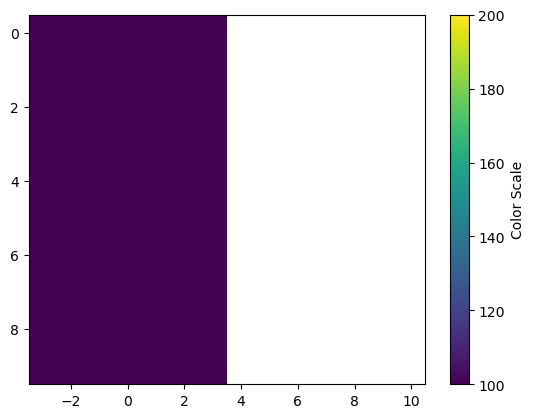

In [21]:
fig, ax = plt.subplots()
plotR = np.append(r,r[-1]+7)
plotZ = np.append(z,z[-1]+0.1)
X, Y = np.meshgrid(plotR, plotZ)
im = ax.pcolormesh(r, z, np.transpose(-20*np.log10(1/np.abs(u[:,1:-1]))), vmin = 100, vmax = 200)
ax.invert_yaxis()
cbar = fig.colorbar(im, ax=ax, label='Color Scale')

In [22]:
u

array([[0.5+0.00000000e+00j, 0.5+0.00000000e+00j, 0.5-8.66025404e-01j,
        0.5+8.66025404e-01j, 0.5-3.06161700e-16j, 0.5-8.66025404e-01j,
        0.5+8.66025404e-01j, 0.5-6.12323400e-16j, 0.5-8.66025404e-01j,
        0.5+8.66025404e-01j, 0.5+8.57871740e-16j, 0.5+1.71574348e-15j],
       [0.5+8.66025404e-01j, nan           +nanj, nan           +nanj,
        nan           +nanj, nan           +nanj, nan           +nanj,
        nan           +nanj, nan           +nanj, nan           +nanj,
        nan           +nanj, nan           +nanj, 0.5+8.66025404e-01j]])

In [4]:
x = None
type(x)
print(type(x) == type(None))

True
